Epoch [1/5], Loss: 0.4538, AUC: 0.9522
Epoch [2/5], Loss: 0.3889, AUC: 0.9889
Epoch [3/5], Loss: 0.3794, AUC: 0.9891
Epoch [4/5], Loss: 0.3740, AUC: 0.9897
Epoch [5/5], Loss: 0.3708, AUC: 0.9891


/tmp/ipykernel_2849/567831921.py:152: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')


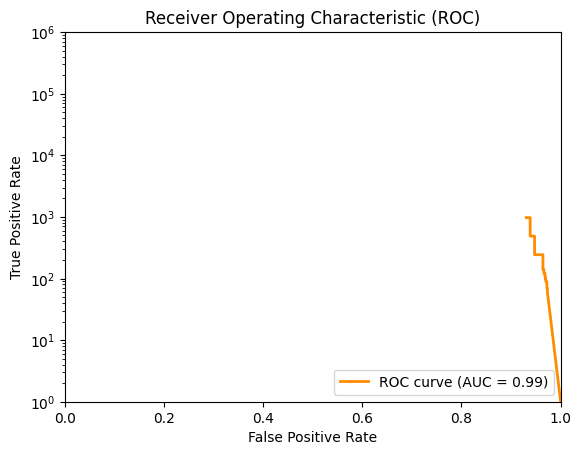

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

# Quantisation functions
def weight_quant(w):
    scale = 1.0 / w.abs().mean().clamp_(min=1e-5)
    w_quant = (w * scale).round().clamp_(-1, 1) / scale
    return w_quant

def activation_quant(x):
    scale = 127.0 / x.abs().max(dim=-1, keepdim=True).values.clamp_(min=1e-5)
    x_quant = (x * scale).round().clamp_(-128, 127) / scale
    return x_quant

class RMSNorm(nn.Module):
    def __init__(self, d):
        super(RMSNorm, self).__init__()
        self.scale = nn.Parameter(torch.ones(d))

    def forward(self, x):
        rms = (x.pow(2).mean(-1, keepdim=True) + 1e-8).sqrt()
        return self.scale * x / rms

# Custom BitLinear layer with quantisation
class BitLinear(nn.Linear):
    def __init__(self, in_features, out_features):
        super(BitLinear, self).__init__(in_features, out_features)  # Pass in_features and out_features to nn.Linear
        self.rmsnorm = RMSNorm(in_features)  # Add RMSNorm for input normalization

    def forward(self, x):
        x_norm = self.rmsnorm(x)  # Apply RMSNorm to input
        x_quant = x_norm + (activation_quant(x_norm) - x_norm).detach()  # STE trick for activations
        w_quant = self.weight + (weight_quant(self.weight) - self.weight).detach()  # STE trick for weights
        y = F.linear(x_quant, w_quant) + self.bias
        return y



# Define the BitNet MLP model
class BitNetMLP(nn.Module):
    def __init__(self):
        super(BitNetMLP, self).__init__()
        self.fc1 = BitLinear(28 * 28, 1)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(x)
        return x

# Function to filter MNIST dataset for digits 8 and 9
def filter_digits(dataset, digits):
    idx = np.isin(dataset.targets, digits)
    dataset.targets = dataset.targets[idx]
    dataset.data = dataset.data[idx]
    return dataset

# Convert the labels 8 -> 0, 9 -> 1
def convert_labels(dataset):
    dataset.targets = torch.where(dataset.targets == 8, 0, 1)  # 8 -> 0, 9 -> 1
    return dataset

# Set up transformations and load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST training and test datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter for digits 8 and 9, then convert labels
mnist_train = filter_digits(mnist_train, [8, 9])
mnist_test = filter_digits(mnist_test, [8, 9])
mnist_train = convert_labels(mnist_train)
mnist_test = convert_labels(mnist_test)

# Create DataLoader objects for training and testing
batch_size = 64
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# Create model and move to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BitNetMLP().to(device)

# Define loss function and optimiser
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    y_true_epoch = []
    y_scores_epoch = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()

        # Forward pass
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Track true labels and predicted probabilities
        y_true_epoch.extend(labels.cpu().numpy())
        y_scores_epoch.extend(outputs.detach().cpu().numpy())

    # Compute AUC for the epoch
    auc_epoch = roc_auc_score(y_true_epoch, y_scores_epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, AUC: {auc_epoch:.4f}')

# Model evaluation
model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze().cpu().numpy()
        y_scores.extend(outputs)
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(tpr, 1/fpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.yscale('log')
plt.xlim([0.0, 1.0])
plt.ylim([1.0, 10e5])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
